In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import functions as f # My functions
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

# Context

In this notebook, I analyze a correlation matrix of asset returns to identify groups of correlated and uncorrelated assets through clustering. The goal is to uncover meaningful structure beyond what is visible from raw correlations alone.

I proceed in the following steps:

### 1. Transform Correlation into a Distance Metric

To apply clustering, I convert the correlation matrix $\rho_{i,j}$ into a distance metric using:

$$
X_{i,j} = \sqrt{\frac{1}{2}(1 - \rho_{i,j})}
$$

This transformation ensures that:
- Distances are non-negative and symmetric,
- Similarities become comparable as distances,
- The correlation matrix implicitly standardizes the variables, so no further normalization is needed.

I use a denoised and detoned version of the correlation matrix to remove noise and eliminate the influence of overall market drift. This allows for capturing more meaningful and non-random dependencies.

### 2. Determine the Number of Clusters

Instead of using the elbow method, I adopt a more data-driven approach inspired by *Andriy Burkov*:

- I split the dataset into a training set and a test set.
- I fit a clustering model on the training set and use it to predict cluster assignments on the test set.
- I then independently cluster the test set itself.
- I compare the cluster assignments obtained from both approaches.

The more appropriate the number of clusters, the higher the agreement in cluster assignments between both methods.

### 3. Select the Best Clustering Using Modified Silhouette Scores

Once the number of clusters is chosen, I rerun the clustering multiple times and select the result with the best silhouette quality, as described by *de Prado*:

For a given data point $i$, the silhouette coefficient $S_i$ is defined as:

$$
S_i = \frac{b_i - a_i}{\max(a_i, b_i)}, \quad i = 1, \dots, N
$$

Where:
- $a_i$ is the average distance to other points in the same cluster,
- $b_i$ is the average distance to the nearest different cluster.

To evaluate clustering quality, I compute:

$$
q = \frac{\mathbb{E}(S_i)}{\operatorname{Var}(S_i)}
$$

This ensures not only that clusters are internally tight, but also that they are well-separated from each other.

### 4. Visualize the Final Clustered Correlation Matrix

Finally, I plot the clustered and reordered correlation matrix. This visualization reveals the identified structure and serves as a tool for further interpretation and analysis.

# Step 1

Transforming the correlation matrix into a distance matrix.

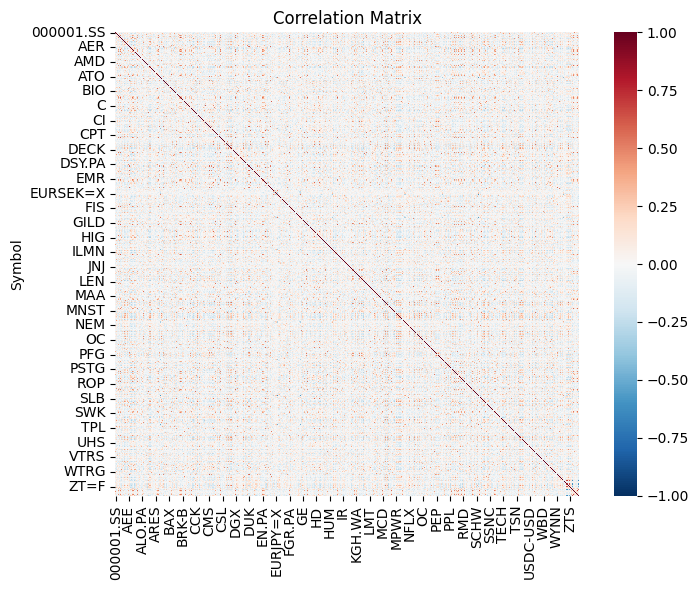

In [2]:
# Using the denoised and detoned corr matrix from sec. 2
corr_matrix = pd.read_csv('denoised_and_detoned_corr_matrix.csv', index_col=0)
corr_matrix = corr_matrix.clip(-1, 1)

f.plot_corr_matrix(corr_matrix)

dist_matrix = np.sqrt(0.5*(1 - corr_matrix))

# Step 2

I choose to use five clusters, as this configuration provides a meaningful level of granularity and demonstrates the best predictive consistency beyond just two clusters. Also, this is confirmed by the silhouette scores - even though 4 clusters have higher silhouette scores, they also have larger standard deviation (than 5 clusters), so 5 clusters is a more stable clusterization.

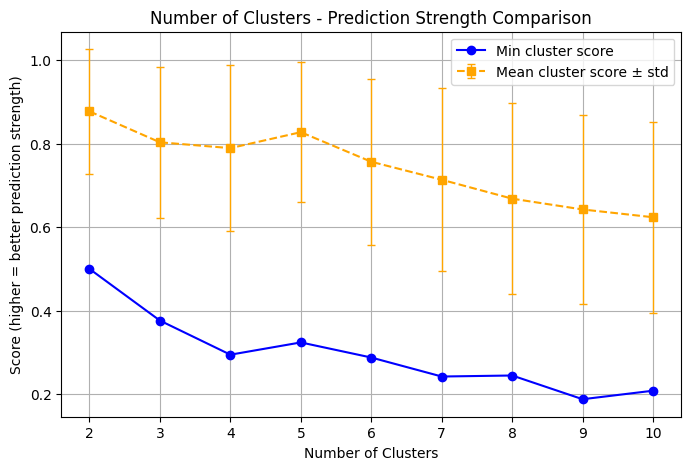

In [3]:
clusters_stats = f.clustering_predictions_strength(dist_matrix, max_n_clusters = 10, test_size=0.5, plot=True)

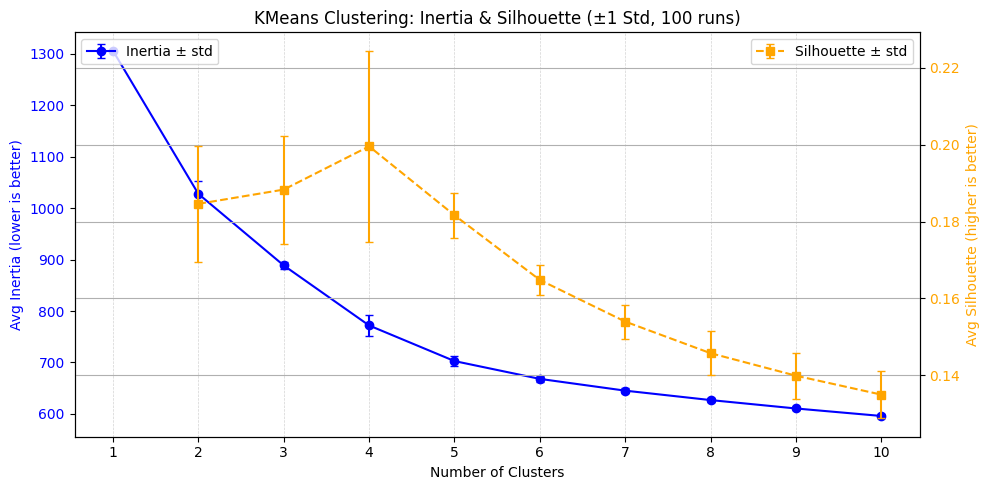

In [4]:
# Elbow plot for comparison

clusters_elbow_stats = f.clustering_elbow_plot(dist_matrix, max_n_clusters = 10, tries_per_n_clusters=100, plot=True)

# Step 3

I determine the optimal clustering by maximizing the silhouette score, which ensures that clusters are not only internally cohesive but also well-separated from one another.

In [5]:
n_clusters = 5

labels, _ = f.find_clustres_with_best_silhouette(dist_matrix, n_clusters)

# Step 4

Plotting the clustered matrix. I additionally sort the matrix by correlations within each cluster, to further improve interpretability.

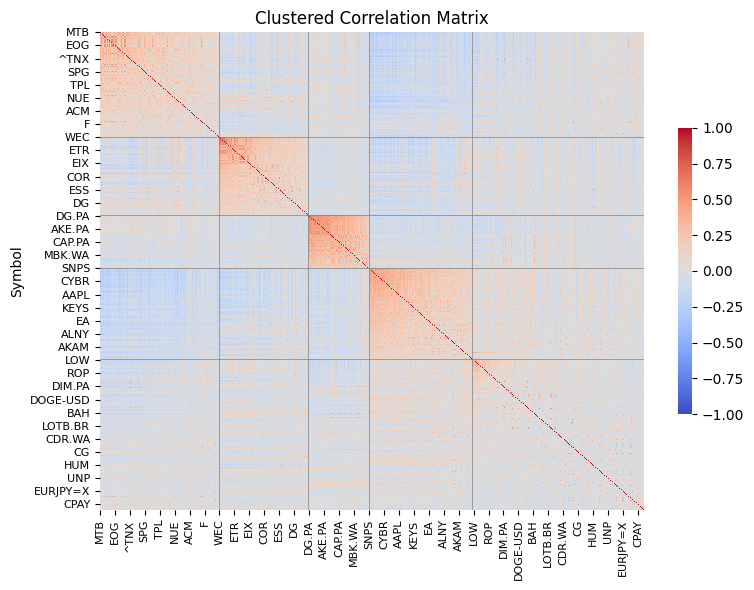

,MTB,MET,SLB,PRU,RF,AIG,FANG,VLO,HBAN,CFG,...,FWONK,ZC=F,CPAY,WBD,TDY,SB=F,VICI,BSX,ZBH,GLPI
Symbol,,,,,,,,,,,,,,,,,,,,,
MTB,1.000000,0.427482,0.230412,0.411106,0.487075,0.346376,0.206355,0.233580,0.492553,0.484094,...,0.007528,-0.001131,0.036141,0.105377,0.027937,-0.041040,0.023427,-0.001165,0.062056,0.046664
MET,0.427482,1.000000,0.259040,0.439134,0.416745,0.409718,0.243725,0.246311,0.421228,0.415870,...,-0.013625,0.023321,0.025175,0.061741,0.024663,0.021339,0.039909,0.006402,0.032446,0.064743
SLB,0.230412,0.259040,1.000000,0.247063,0.226143,0.250169,0.566969,0.519548,0.215780,0.214933,...,-0.004505,0.135356,0.095437,-0.030643,-0.015334,0.094006,0.003274,-0.014443,0.020483,0.034061
PRU,0.411106,0.439134,0.247063,1.000000,0.392436,0.402578,0.215643,0.239844,0.401019,0.389203,...,-0.002676,0.027556,0.059978,0.069459,0.015826,0.019192,0.028392,0.005945,0.044384,0.059225
RF,0.487075,0.416745,0.226143,0.392436,1.000000,0.330285,0.198096,0.237536,0.490067,0.490213,...,-0.001828,0.001457,0.026606,0.116462,-0.010034,-0.021627,0.041909,-0.050814,0.029342,0.046036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SB=F,-0.041040,0.021339,0.094006,0.019192,-0.021627,0.030759,0.115448,0.130793,-0.026559,-0.011063,...,0.033892,0.212354,0.043156,0.035471,-0.002137,1.000000,0.036564,-0.040312,0.072611,0.009326
VICI,0.023427,0.039909,0.003274,0.028392,0.041909,0.049961,0.022649,0.016522,0.023018,0.026114,...,0.072674,-0.018259,-0.013614,0.060559,-0.022286,0.036564,1.000000,0.006306,0.076810,0.395354
BSX,-0.001165,0.006402,-0.014443,0.005945,-0.050814,0.011504,-0.015060,-0.008110,-0.032861,-0.037510,...,0.081828,-0.013445,0.108501,-0.093755,0.066186,-0.040312,0.006306,1.000000,0.254393,0.028103


In [6]:
f.sort_clustered_corr_matrix(corr_matrix, labels, label_spacing=20, plot = True)